In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import griddata
import scipy.interpolate as inter
import sys, time, timeit
from streamplot import streamplot
import read as read
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
import copy
from scipy import interpolate
from scipy import signal
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
import amrplot
import pickle
import numpy_support as ah
import math
from scipy.optimize import fsolve
import pandas as pd

In [147]:
#path='../tracer/out_madfm_hres/'
path1='../tracer/mad_ideal_refine_3_384x192/'
path2='../tracer/mad_ideal_refine_3_192x96/'
path3='../tracer/mad_ideal_refine_3_96x48/'

In [148]:
offset1=400
offset2=400
offset3=400

d1=read.load(offset1, file=path1+'data',type='vtu', silent=1);
d2=read.load(offset2, file=path2+'data',type='vtu', silent=1);
d3=read.load(offset3, file=path3+'data',type='vtu', silent=1);


In [138]:
class MADBins:
    def __init__(self, data):#, bindata):
        cellCent=data.getCenterPoints()
        xCent=cellCent.transpose()[0]
        yCent=cellCent.transpose()[1]
        theta=np.arctan(yCent/xCent)
        def cart2polar(pts):
            r0=np.sqrt(pts[0][0]**2+pts[0][1]**2)
            r1=np.sqrt(pts[1][0]**2+pts[1][1]**2)
            dr=r1-r0
            th0=np.arctan(pts[0][1]/pts[0][0])
            th1=np.arctan(pts[2][1]/pts[2][0])
            dth=th0-th1
            return dr, dth, r1, r0, th0, th1
        coord=np.array([cart2polar(data.getVert(item)) for item in range(len(data.rho))]).transpose()
        mCell=data.rho * data.sqrtgamma * data.alpha * coord[0] * coord[1] * data.lfac 
        tCell=data.rho * data.tr1 * data.sqrtgamma * data.alpha * coord[0] * coord[1] * data.lfac 
#        (nbs, xmin, xmax, log)=bindata
#        grid1=np.linspace(np.log10(xmin),np.log10(xmax),nbs) if logX else np.linspace(xmin,xmax,nbs)
#        self.grid=[10**item for item in grid1]
        self.df=pd.DataFrame({'rhomass': mCell,
                         'tr1mass': tCell,
                         'xcent': xCent,
                         'ycent': yCent,
                         'theta': theta,
                         'rin': coord[3],
                         'rout': coord[2],
                         'drdth': abs(coord[0]*coord[1]),
                         'sqrtg': data.sqrtgamma})
        
    def getInfo(self):
        return self.df
        
    def getBinning(self, binvar, rmax, bindata, rmin=None):
        (nbs, xmin, xmax, log)=bindata
        grid1=np.linspace(np.log10(xmin),np.log10(xmax),nbs) if logX else np.linspace(xmin,xmax,nbs)
        grid=[10**item for item in grid1]
        dft=self.df.copy(deep=True)
        dft['binvar']=binvar
        dft['bin']=pd.cut(dft['binvar'],grid,right=False, include_lowest=True, precision=5)
        dft=dft[dft.rout<rmax]
        dft=dft[dft.rin>rmin] if rmin!=None else dft
        dft=dft.dropna()
        return dft.groupby('bin', as_index=False).agg({'rhomass': 'sum', 'tr1mass':'sum'})

    def getBinning2(self, binvar, rmax, rmin=None):
        dft=self.df.copy(deep=True)
        dft['binvar']=binvar
        dft['bin']=pd.cut(dft['binvar'],self.grid,right=False, include_lowest=True, precision=5)
        dft=dft[(dft.xcent**2+dft.ycent**2)<rmax**2]
        dft=dft[(dft.xcent**2+dft.ycent**2)>rmin**2] if rmin!=None else dft 
        dft=dft.dropna()
        return dft.groupby('bin', as_index=False).agg({'rhomass': 'sum', 'tr1mass':'sum'})
    
    
    def getBinningFixR(self, binvar, r):
        dft=self.df.copy(deep=True)
        dft['binvar']=binvar
        dft['bin']=pd.cut(dft['binvar'],self.grid,right=False, include_lowest=True, precision=5)
        dft=dft[(dft.vertin<r) & (dft.vertout>r)]
        dft=dft.dropna()
        return dft.groupby('bin', as_index=False).agg({'rhomass': 'sum', 'tr1mass':'sum'})    

    
    def plot(self, bindf,logX, logY, ax, xlim=None, ylim=None):
        def intervalFun(interval,log):
            left=np.array([item.left for item in interval])
            right=np.array([item.right for item in interval])
            left=np.log10(left) if log else left
            right=np.log10(right) if log else right
            mid=(right+left)/2
            width=right-left
            return (left,mid,right, width)
        (left,mid,right,width)=intervalFun(bindf.bin,logX)
        bindf['width']=width
        normrho=np.array(bindf.rhomass / bindf.width)
        normtr1=np.array(bindf.tr1mass / bindf.width)
        ax.plot(mid,np.log10(normrho) if logY else normrho,label='rho, t=4000')
        ax.plot(mid,np.log10(normtr1) if logY else normtr1,label='dtr, t=4000')
        if xlim!=None: ax.set_xlim(xlim)
        if ylim!=None: ax.set_ylim(ylim)
            
    def plot_ratio(self, bindf,logX, logY, ax, label, xlim=None, ylim=None):
        def intervalFun(interval,log):
            left=np.array([item.left for item in interval])
            right=np.array([item.right for item in interval])
            left=np.log10(left) if log else left
            right=np.log10(right) if log else right
            mid=(right+left)/2
            width=right-left
            return (left,mid,right, width)
        (left,mid,right,width)=intervalFun(bindf.bin,logX)
        bindf['width']=width
        normrho=np.array(bindf.rhomass / bindf.width)
        normtr1=np.array(bindf.tr1mass / bindf.width)
        ax.plot(mid, np.log10(normtr1/normrho) if logY else normrho,label=label)
        if xlim!=None: ax.set_xlim(xlim)
        if ylim!=None: ax.set_ylim(ylim)

In [ ]:
nbs=100
radcap=100
radfloor=None
xmin=1e-10
xmax=25
logX=True
logY=True
xlim=(-2.5,0.7)
ylim=(0,12)


                
bindata=(nbs, xmin, xmax, True)      
mad=MADBins(d2, bindata)
info=mad.getInfo()
info

In [ ]:
def cart2polar(pts):
    r0=np.sqrt(pts[0][0]**2+pts[0][1]**2)
    r1=np.sqrt(pts[1][0]**2+pts[1][1]**2)
    dr=r1-r0
    th0=np.arctan(pts[0][1]/pts[0][0])
    th1=np.arctan(pts[2][1]/pts[2][0])
    dth=th0-th1
    return abs(dr*dth), r1, r0, th0, th1

(dvol,_,_,_,_)=np.array([cart2polar(d2.getVert(item)) for item in range(len(d2.rho))]).transpose()

In [ ]:
from scipy.signal import savgol_filter

def getShell(y, df0, r, rho, dtr):
    df=df0.copy(deep='true')
    df['rho']=rho
    df['dtr']=dtr
    df['y']=y
    df=df[(df.rin<r) & (df.rout>r)]
    df=df[df.theta>=0]
    df=df.sort_values(by=['theta'])
    x=np.array(df.theta*180/np.pi)
    y=np.array(df.y)
    return x,y,df


def norm(y,log=True, norm=True):
    yy=np.log(y) if log else y
    return (yy-min(yy))/(max(yy)-min(yy)) if norm else yy

r=100



rho=d2.rho
tr1=np.clip(d2.tr1,1e-20,max(d2.tr1))
dtr=rho*tr1

h1=rho+4*d2.p
h2=dtr+4*d2.p

B2=d2.b1**2+d2.b2**2+d2.b3**2
sigma_d=B2/rho
sigma_t=B2/dtr

(x,b2,df)=getShell(B2, info[0],r, d2.rho, dtr)
(x,b0,df)=getShell(sigma_d, info[0],r, rho, dtr)
(x,b1,df)=getShell(sigma_t, info[0],r, rho, dtr)
(x,lfac,df)=getShell(d2.lfac,info[0],r, d2.rho, dtr)
rho0=norm(np.array(df.rho),True, norm=False)
rho1=savgol_filter(rho0, 51, 3)
dtr0=norm(np.array(df.dtr),True, norm=False)
dtr1=savgol_filter(dtr0, 51, 3)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

#ax2.plot(x,norm(b2,log=False, norm=True),label=r'magnetic energy', color='red', linestyle='solid', linewidth='3')
ax2.plot(x,norm(b0,log=True, norm=False),label=r'$\sigma_{hot}$ (rho)', color='red', linestyle='solid', linewidth='3')
ax2.plot(x,norm(b1,log=True, norm=False),label=r'$\sigma_{hot}$ (tracer)', color='blue', linestyle='solid', linewidth='3')
ax1.plot(x,rho0,label=r'rho',color='orange', linestyle='solid', linewidth='3')
ax1.plot(x,dtr0,label=r'tracer',color='green', linestyle='--', linewidth='3')

#plt.plot(x,(lfac-min(lfac))/(max(lfac)-min(lfac)))
plt.xlim([0,90])
#plt.ylim([0,0.00125])
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='center', fontsize=20)

ax1.set_xlabel(r'$\theta$ in radian', fontsize=20)
ax1.set_ylabel(r'log[density]', fontsize=20)
ax2.set_ylabel(r'$\sigma$',fontsize=20)


In [ ]:
np.log10(max(b1))

In [ ]:
B2 = d2.b1**2 + d2.b2**2 + d2.b3**2
h=1
tr1=np.clip(d2.tr1,1e-20,max(d2.tr1))
dtr=d2.rho*tr1
rsigma_cold=B2/(d2.rho*h)
tsigma_cold=B2/(dtr*h)

df=info[0]
df['rsigma']=rsigma_cold
df['tsigma']=tsigma_cold
df['theta']=np.arctan(df['ycent']/df['xcent'])
df1=df[(df.vertin<2000) & (df.vertout>2000)]
df1=df1.sort_values(by=['theta'])
cs=inter.interp1d(df.theta, df.rsigma,fill_value="extrapolate")
cs2=inter.interp1d(df.theta, df.tsigma,fill_value="extrapolate")
x=np.linspace(0.001,2*np.pi-0.001,100)
plt.plot(x,np.log10(cs(x)))
plt.plot(x,np.log10(cs2(x)))
df1

In [ ]:
vert=d2.getVert(1000)
test=(np.arctan(vert[0][1]/vert[0][0]), np.arctan(vert[1][1]/vert[1][0]), np.arctan(vert[2][1]/vert[2][0]), np.arctan(vert[3][1]/vert[3][0]))
#test=(vert[0][1]**2+vert[0][0]**2,vert[1][1]**2+vert[1][0]**2,vert[2][1]**2+vert[2][0]**2,vert[3][1]**2+vert[3][0]**2)

def cart2polar(pts):
    r0=np.sqrt(pts[0][0]**2+pts[0][1]**2)
    r1=np.sqrt(pts[1][0]**2+pts[1][1]**2)
    dr=r1-r0
    th0=np.arctan(vert[0][1]/vert[0][0])
    th1=np.arctan(vert[2][1]/vert[2][0])
    dth=th0-th1
    return dr, dth, r1, r0, th0, th1

polar=np.array([cart2polar(d2.getVert(item)) for item in range(len(d2.rho))])


In [149]:
mad1=MADBins(d1)
mad2=MADBins(d2)
mad3=MADBins(d3)

/tmp/ipykernel_2384985/1923564796.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  th0=np.arctan(pts[0][1]/pts[0][0])


/tmp/ipykernel_2384985/1923564796.py:78: RuntimeWarning: divide by zero encountered in log10
  ax.plot(mid,np.log10(normrho) if logY else normrho,label='rho, t=4000')
/tmp/ipykernel_2384985/1923564796.py:79: RuntimeWarning: divide by zero encountered in log10
  ax.plot(mid,np.log10(normtr1) if logY else normtr1,label='dtr, t=4000')


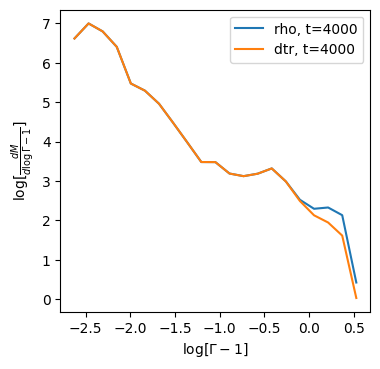

In [203]:
nbs=200
radcap=100
radfloor=80
xmin=1e-30
xmax=25
logX=True
logY=True
xlim=(-2.5,0.7)
ylim=(-1,8)


                
bindata=(nbs, xmin, xmax, True)      
dff=mad1.getBinning(d1.lfac-1, rmax=radcap, rmin=radfloor, bindata=bindata)
df=mad1.getInfo()


fig=plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_subplot(1, 1, 1)

mad1.plot(dff,logX,logY,ax)#, xlim,ylim)
#mad.plot_ratio(dff,logX,True,ax, xlim)
ax.set_xlabel(r'$\log [\Gamma-1]$')
ax.set_ylabel(r'$\log[\frac{dM}{d\log\Gamma-1}]$')
ax.legend()
#plt.savefig("mass_vs_gamma_minus_1.pdf", bbox_inches='tight', transparent=True, pad_inches=0)

/tmp/ipykernel_2384985/1923564796.py:96: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(mid, np.log10(normtr1/normrho) if logY else normrho,label=label)
/tmp/ipykernel_2384985/1923564796.py:96: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(mid, np.log10(normtr1/normrho) if logY else normrho,label=label)
/tmp/ipykernel_2384985/1923564796.py:96: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(mid, np.log10(normtr1/normrho) if logY else normrho,label=label)


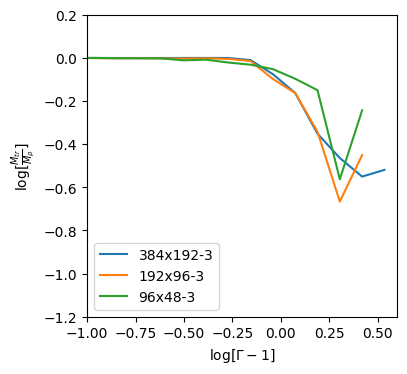

In [209]:
nbs=100
xmin=1e-10
xmax=25
logX=True
logY=True
xlim=(-1,0.6)
ylim=(-1.2,0.2)


radcap=100
radfloor=80               
bindata=(nbs, xmin, xmax, True)      
df100=mad1.getBinning(d1.lfac-1, rmax=radcap, rmin=radfloor, bindata=bindata)

radcap=100
radfloor=80
df80=mad2.getBinning(d2.lfac-1, rmax=radcap, rmin=radfloor, bindata=bindata)

radcap=100
radfloor=80
df60=mad3.getBinning(d3.lfac-1, rmax=radcap, rmin=radfloor, bindata=bindata)

radcap=100
radfloor=80
#df40=mad3.getBinning(d2.lfac-1, rmax=radcap, rmin=radfloor, bindata=bindata)

radcap=20
radfloor=0
#df20=mad3.getBinning(d2.lfac-1, rmax=radcap, rmin=radfloor, bindata=bindata)

fig=plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_subplot(1, 1, 1)

#ad.plot(dff,logX,logY,ax)#, xlim,ylim)
mad.plot_ratio(df100,logX,logY,ax, '384x192-3', xlim, ylim)
mad.plot_ratio(df80,logX,logY,ax, '192x96-3', xlim, ylim)
mad.plot_ratio(df60,logX,logY,ax, '96x48-3',xlim, ylim)
#mad.plot_ratio(df40,logX,logY,ax, '0 < r < 40',xlim)
#mad.plot_ratio(df20,logX,logY,ax, '0 < r < 20',xlim)

ax.set_xlabel(r'$\log [\Gamma-1]$')
ax.set_ylabel(r'$\log[\frac{M_{tr}}{M_\rho}]$')
ax.legend()
#plt.savefig("mass_ratio_vs_gamma_minus_1.pdf", bbox_inches='tight', transparent=True, pad_inches=0)

In [143]:
len(d2.lfac)

222720

/tmp/ipykernel_2384985/1923564796.py:78: RuntimeWarning: divide by zero encountered in log10
  ax.plot(mid,np.log10(normrho) if logY else normrho,label='rho, t=4000')
/tmp/ipykernel_2384985/1923564796.py:79: RuntimeWarning: divide by zero encountered in log10
  ax.plot(mid,np.log10(normtr1) if logY else normtr1,label='dtr, t=4000')


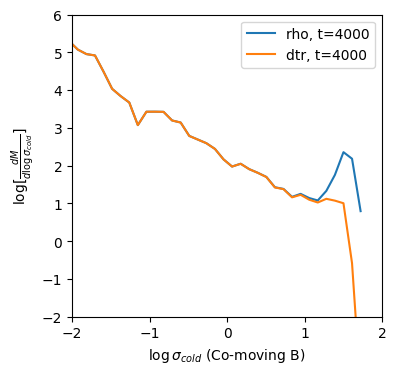

In [207]:
nbs=200
radcap=100
radfloor=80
xmin=1e-20
xmax=100
logX=True
logY=True
xlim=(-2,2)
ylim=(-2,6)

bindata=(nbs, xmin, xmax, True)
dff=mad1.getBinning(d1.sigma,rmax=radcap, rmin=radfloor, bindata=bindata)
fig=plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_subplot(1, 1, 1)
mad1.plot(dff,True,True,ax, xlim,ylim)
ax.set_xlabel(r'$\log \sigma_{cold}$ (Co-moving B)')
ax.set_ylabel(r'$\log[\frac{dM}{d\log\sigma_{cold}}]$')
ax.legend()
#plt.savefig("mass_vs_sigma_cold.pdf", bbox_inches='tight', transparent=True, pad_inches=0)

In [ ]:
nbs=100
radcap=100
radfloor=80
xmin=1e-10
xmax=300
logX=True
logY=True
xlim=(-2.5,3)
ylim=(-2,7)


B2 = d2.b1**2 + d2.b2**2 + d2.b3**2
tr1=np.clip(d2.tr1,1e-20,max(d2.tr1))
dtr=d2.rho*tr1
rho=d2.rho
h1=rho+4*d2.p
h2=dtr+4*d2.p
rsigma_hot=B2/h1
tsigma_hot=B2/h2



bindata=(nbs, xmin, xmax, True)
mad2=MADBins(d2, bindata)
rhodf=mad2.getBinning(rsigma_hot,radcap, radfloor)
tr1df=mad2.getBinning(tsigma_hot,radcap, radfloor)
fig=plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_subplot(1, 1, 1)
#mad2.plot(dff2,True,True,ax)
dm=rhodf.rhomass
tm=tr1df.tr1mass
joindf=rhodf[['bin','rhomass']]
joindf['tr1mass']=tm
mad2.plot(joindf,logX,logY,ax,xlim,ylim)
ax.set_xlabel(r'$\log \sigma_{hot}$ (Eulerian B)')
ax.set_ylabel(r'$\log[\frac{dM}{d\log\sigma_{hot}}]$')
ax.legend()

In [ ]:
max(h2)

In [ ]:
nbs=100
radcap=100
radfloor=80
xmin=1e-10
xmax=300
logX=True
logY=True
xlim=(-2.5,3)
ylim=(0,7)


B2 = d2.b1**2 + d2.b2**2 + d2.b3**2
tr1=np.clip(d2.tr1,1e-20,max(d2.tr1))
dtr=d2.rho*tr1
rho=d2.rho
h1=rho
h2=dtr
rsigma_hot=B2/h1#(d2.rho)
tsigma_hot=B2/h2#(dtr)


bindata=(nbs, xmin, xmax, True)
mad2=MADBins(d2, bindata)
rhodf=mad2.getBinning(rsigma_hot,radcap, radfloor)
tr1df=mad2.getBinning(tsigma_hot,radcap, radfloor)
fig3=plt.figure(figsize=(4,4),dpi=100)
ax3 = fig3.add_subplot(1, 1, 1)
#mad2.plot(dff2,True,True,ax)
dm=rhodf.rhomass
tm=tr1df.tr1mass
joindf=rhodf[['bin','rhomass']]
joindf['tr1mass']=tm
mad2.plot(joindf,logX,logY,ax3,xlim,ylim)
ax3.set_xlabel(r'$\log \sigma_{cold}$ (Eulerian B)')
ax3.set_ylabel(r'$\log[\frac{dM}{d\log\sigma_{cold}}]$')
ax3.legend()

In [ ]:
xmax=100
logX=True
logY=True
xlim=(-2.5,2)
ylim=(3,11)


B2 = d2.b1**2 + d2.b2**2 + d2.b3**2
h=1
tr1=np.clip(d2.tr1,1e-20,max(d2.tr1))
dtr=d2.rho*tr1
rsigma_hot=B2/(d2.rho*h)
tsigma_hot=B2/(dtr*h)


bindata=(nbs, xmin, xmax, True)
mad2=MADBins(d2, bindata)
rhodf=mad2.getBinningFixR(rsigma_hot,100)
tr1df=mad2.getBinningFixR(tsigma_hot,100)
fig3=plt.figure(figsize=(4,4),dpi=100)
ax3 = fig3.add_subplot(1, 1, 1)
#mad2.plot(dff2,True,True,ax)
dm=rhodf.rhomass
tm=tr1df.tr1mass
joindf=rhodf[['bin','rhomass']]
joindf['tr1mass']=tm
mad2.plot(joindf,logX,logY,ax3)#,xlim,ylim)
ax3.set_xlabel(r'$\log \sigma_{cold}$ (Eulerian B)')
ax3.set_ylabel(r'$\log[\frac{dM}{d\log\sigma_{cold}}]$')
ax3.legend()

In [ ]:
xrng=[0,100]
yrng=[-100,100]
fig=plt.figure(figsize=(7,7),dpi=100)
ax = fig.add_subplot(1, 1, 1)
p1=polyplot(np.log10(d2.lfac-1),d2,xrange=xrng,yrange=yrng, fig=fig, axis=ax, max=1, min=-4, cmap='jet')
p1.ax.set_xlabel('radius')
p1.cbar.ax.set_ylabel(r'$\log_{10}(\Gamma$-1)')

In [ ]:
d2.getVarnames()

In [ ]:
test=d2.getVert(865536)
test

In [ ]:
t1=test[3]
t1[0]**2+t1[1]**2

In [ ]:
vertices=[d2.getVert(idx) for idx in range(len(d2.rho))]

In [ ]:
vertin=[item[0][0]**2+item[0][1]**2 for item in vertices]
vertout=[item[1][0]**2+item[1][1]**2 for item in vertices]

In [ ]:
vertout

In [ ]:
path='../tracer/out_madfm_lres/'
offset=400
ddd=read.load(offset, file=path+'data',type='vtu', silent=1);
len(ddd.d)

In [ ]:
#!/usr/bin/env python
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import ndimage
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import read,amrplot

import argparse

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

def get_args():
    p = argparse.ArgumentParser()
    p.add_argument("i0", type=int, help="Start index")
    p.add_argument("i1", type=int, help="End index")
    #p.add_argument("nd", type=int, help="Field line density")
    #p.add_argument("x_range", type=float, nargs=2, help="x0 and x1")
    #p.add_argument("y_range", type=float, nargs=2, help="y0 and y1")
    return p.parse_args()

a = 0.99
rplus = 1.+np.sqrt(1-a**2)
th = np.linspace(0.,np.pi,1000)
xh = rplus*np.sin(th)
yh = rplus*np.cos(th)
rerg = 1.+np.sqrt(1.-a**2*np.cos(th)**2)
xe = rerg*np.sin(th)
ye = rerg*np.cos(th)

## Metric components

def delta(r,th):
    return r**2 + a**2 -2.*r

def rhosq(r,th):
    return r**2 + a**2 * np.cos(th)**2

def z(r,th):
    return 2.*r/rhosq(r,th)

def sigsq(r,th):
    return (r**2 + a**2)**2 - a**2 * delta(r,th) * np.sin(th)**2

def grd(r,th):
    return 1 + z(r,th)

def gthd(r,th):
    return rhosq(r,th)

def gphd(r,th):
    return sigsq(r,th)*(np.sin(th)**2) / rhosq(r,th)

def gphrd(r,th):
    return -a*(np.sin(th)**2)*(1.+z(r,th))

def sqrt_gam(r,th):
    return rhosq(r,th) * np.sin(th) * np.sqrt(1. + z(r,th))

def alpha(r,th):
    return 1./np.sqrt(1.+z(r,th))

def gru(r,th):
    return sigsq(r,th) / (rhosq(r,th)*(rhosq(r,th)+(2.*r)))


# Function to re-grid data

def regrid(var_list, x1_list, x2_list, n1, n2, x1min, x1max, x2min, x2max):

    points = np.vstack((x1_list, x2_list)).T

    nregrid = [n1, n2]

    x1_range = [x1min, x1max]
    x2_range = [x2min, x2max]

    tmp0 = np.complex(0, nregrid[0])
    tmp1 = np.complex(0, nregrid[1])
    grid_x1, grid_x2 = np.mgrid[x1_range[0]:x1_range[1]:tmp0,
                              x2_range[0]:x2_range[1]:tmp1]

    gridvar = griddata(points, var_list, (grid_x1, grid_x2), method='linear')

    isnan = np.isnan(gridvar)
    gridvar[isnan] = griddata(points, var_list, (grid_x1[isnan], grid_x2[isnan]),
                              method='nearest')

    # smooth the data slightly:
    blurred_gridvar = ndimage.gaussian_filter(gridvar, sigma=1.0)

    x1 = np.linspace(x1_range[0],x1_range[1],nr)
    x2 = np.linspace(x2_range[0],x2_range[1],nth)

    x1_new,x2_new=np.meshgrid(x1,x2,indexing='ij')

    return blurred_gridvar, x1_new, x2_new


d2.thetaMKS

In [ ]:
#!/usr/bin/env python
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import ndimage
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import read,amrplot

import argparse

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

def get_args():
    p = argparse.ArgumentParser()
    p.add_argument("i0", type=int, help="Start index")
    p.add_argument("i1", type=int, help="End index")
    #p.add_argument("nd", type=int, help="Field line density")
    #p.add_argument("x_range", type=float, nargs=2, help="x0 and x1")
    #p.add_argument("y_range", type=float, nargs=2, help="y0 and y1")
    return p.parse_args()

args = get_args()

a = 0.99
rplus = 1.+np.sqrt(1-a**2)
th = np.linspace(0.,np.pi,1000)
xh = rplus*np.sin(th)
yh = rplus*np.cos(th)
rerg = 1.+np.sqrt(1.-a**2*np.cos(th)**2)
xe = rerg*np.sin(th)
ye = rerg*np.cos(th)

## Metric components

def delta(r,th):
    return r**2 + a**2 -2.*r

def rhosq(r,th):
    return r**2 + a**2 * np.cos(th)**2

def z(r,th):
    return 2.*r/rhosq(r,th)

def sigsq(r,th):
    return (r**2 + a**2)**2 - a**2 * delta(r,th) * np.sin(th)**2

def grd(r,th):
    return 1 + z(r,th)

def gthd(r,th):
    return rhosq(r,th)

def gphd(r,th):
    return sigsq(r,th)*(np.sin(th)**2) / rhosq(r,th)

def gphrd(r,th):
    return -a*(np.sin(th)**2)*(1.+z(r,th))

def sqrt_gam(r,th):
    return rhosq(r,th) * np.sin(th) * np.sqrt(1. + z(r,th))

def alpha(r,th):
    return 1./np.sqrt(1.+z(r,th))

def gru(r,th):
    return sigsq(r,th) / (rhosq(r,th)*(rhosq(r,th)+(2.*r)))


# Function to re-grid data

def regrid(var_list, x1_list, x2_list, n1, n2, x1min, x1max, x2min, x2max):

    points = np.vstack((x1_list, x2_list)).T

    nregrid = [n1, n2]

    x1_range = [x1min, x1max]
    x2_range = [x2min, x2max]

    tmp0 = np.complex(0, nregrid[0])
    tmp1 = np.complex(0, nregrid[1])
    grid_x1, grid_x2 = np.mgrid[x1_range[0]:x1_range[1]:tmp0,
                              x2_range[0]:x2_range[1]:tmp1]

    gridvar = griddata(points, var_list, (grid_x1, grid_x2), method='linear')

    isnan = np.isnan(gridvar)
    gridvar[isnan] = griddata(points, var_list, (grid_x1[isnan], grid_x2[isnan]),
                              method='nearest')

    # smooth the data slightly:
    blurred_gridvar = ndimage.gaussian_filter(gridvar, sigma=1.0)

    x1 = np.linspace(x1_range[0],x1_range[1],nr)
    x2 = np.linspace(x2_range[0],x2_range[1],nth)

    x1_new,x2_new=np.meshgrid(x1,x2,indexing='ij')

    return blurred_gridvar, x1_new, x2_new



nr=1500
nth=1500


for i in range(args.i0, args.i1+1, 3):

    # Read the vtk

    d=read.load_vtkfile(i,file='./output/data',type='vtu')

    # Modified KS theta

    h=0.35

    theta=d.thetaMKS + h*(2.*d.thetaMKS/(math.pi**2))*(math.pi-(2.*d.thetaMKS))*(math.pi-d.thetaMKS)


    # Regrid the cartesianized EB components (they are in the coordinate basis)

    B1_regrid = regrid(d.b1, np.exp(d.rMKS), theta, nr, nth, 1, 20, 0, math.pi)
    B1 = B1_regrid[0]
    r = B1_regrid[1]
    th = B1_regrid[2]
    np.savetxt('r.txt', r[:,0])
    np.savetxt('theta.txt', th[0,:])

    print("b1 done")

    B2_regrid = regrid(d.b2, np.exp(d.rMKS), theta, nr, nth, 1, 20, 0, math.pi)
    B2 = B2_regrid[0]

    print("b2 done")


    B3_regrid = regrid(d.b3, np.exp(d.rMKS), theta, nr, nth, 1, 10, 0, math.pi)
    B3 = B3_regrid[0]

    print("b3 done")


    E1_regrid = regrid(d.e1, np.exp(d.rMKS), theta, nr, nth, 1, 10, 0, math.pi)
    E1 = E1_regrid[0]

    print("e1 done")


    E2_regrid = regrid(d.e2, np.exp(d.rMKS), theta, nr, nth, 1, 10, 0, math.pi)
    E2 = E2_regrid[0]

    print("e2 done")


    E3_regrid = regrid(d.e3, np.exp(d.rMKS), theta, nr, nth, 1, 10, 0, math.pi)
    E3 = E3_regrid[0]

    print("e3 done")


    # Convert cartesianized K.S. components to spherical components

    Br = np.sin(th)*B1 + np.cos(th)*B2
    Bth = np.cos(th)*B1 - np.sin(th)*B2
    Bph = B3

    Er = np.sin(th)*E1 + np.cos(th)*E2
    Eth = np.cos(th)*E1 - np.sin(th)*E2
    Eph = E3



    # Save to .txt files

    np.savetxt('Br.txt', Br, delimiter = ',')
    np.savetxt('Bth.txt', Bth, delimiter = ',')
    np.savetxt('Bph.txt', Bph, delimiter = ',')

    np.savetxt('Er.txt', Er, delimiter = ',')
    np.savetxt('Eth.txt', Eth, delimiter = ',')
    np.savetxt('Eph.txt', Eph, delimiter = ',')




    # Get the flux function

    # Aph = 0.0*Br
    #
    #
    # for ir in range(nr):
    #     for j in range(nth-1):
    #         dth = th[1,j+1]-th[1,j]
    #         Aph[ir,j+1] = Aph[ir,j] + dth*(Br[ir,j]*sqrt_gam(r[ir,j],th[ir,j]))
    #
    #
    # Aph[:,0]=0.0
    # Aph[:,-1]=0.0

    # Save to file

    #np.savetxt('Aph.txt', Aph , delimiter = ',')

    print("Complete !")